### Ipynb 1/3 Preprocessing 
# Machine Learning Regression for proactive attack pattern detection in IoT networks

By **predicting** `flow_duration` **from basic network telemetry** in real-time IoT traffic, we can spot unusual resource use early and surface potential attack patterns before they escalate. This enables proactive capacity planning *(autoscaling, QoS tuning)* and faster security response, reducing downtime and operating costs while keeping connected devices reliable.

In line with **SDG 9 *(Industry, Innovation & Infrastructure)*** and **SDG 16 *(Peace, Justice & Strong Institutions)***, this approach strengthens digital infrastructure and improves cyber-resilience for services that increasingly depend on IoT.

**Impact:** Securing IoT networks helps keep critical infrastructure - such as smart cities, healthcare, and energy systems - safe and reliable. **Concretely,** this means hospital sensor networks remain stable and smart city street lighting is protected from attack-driven disruptions.

## 1. Load and clean data

### Exploratory note
Because **IoT** is kinda new to me, I started with a **500-row sample**. From that sample I **defined all columns** (name, type, meaning, etc.) to build a quick idea of the dataset.

I then ran a **quick correlation heatmap** on numeric columns to check if there’s **any signal** worth pursuing (incl. potential target like `flow_duration`). This is only a sanity check—correlation ≠ causation, and 500 rows is directional.

**Kept in Notion (definitions & usage plan):**  
[Dataset index](https://www.notion.so/Dataset-index-25898c6768cd80579f7dcc23e99f9c7a)

**Conclusion** 
Correlations look plausible to work with.

### 1.1 Load data with ucimlrepo
Loading the data with the 'import in Python' function from https://archive.ics.uci.edu/dataset/942/rt-iot2022 then convert to a SQL lite database to work with



In [183]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
rt_iot2022 = fetch_ucirepo(id=942) 
  
# data (as pandas dataframes) 
X = rt_iot2022.data.features 
y = rt_iot2022.data.targets 
  
# metadata 
print(rt_iot2022.metadata) 
  
# variable information 
print(rt_iot2022.variables) 


{'uci_id': 942, 'name': 'RT-IoT2022 ', 'repository_url': 'https://archive.ics.uci.edu/dataset/942/rt-iot2022', 'data_url': 'https://archive.ics.uci.edu/static/public/942/data.csv', 'abstract': 'The RT-IoT2022, a proprietary dataset derived from a real-time IoT infrastructure, is introduced as a comprehensive resource integrating a diverse range of IoT devices and sophisticated network attack methodologies. This dataset encompasses both normal and adversarial network behaviours, providing a general representation of real-world scenarios.\nIncorporating data from IoT devices such as ThingSpeak-LED, Wipro-Bulb, and MQTT-Temp, as well as simulated attack scenarios involving Brute-Force SSH attacks, DDoS attacks using Hping and Slowloris, and Nmap patterns, RT-IoT2022 offers a detailed perspective on the complex nature of network traffic. The bidirectional attributes of network traffic are meticulously captured using the Zeek network monitoring tool and the Flowmeter plugin. Researchers can

### Project paths

To keep file paths consistent across notebooks, we define the project root dynamically.  
The `find_repo_root` function walks up the directory tree and looks for indicators of the repo root:  
- a `.git` folder (typical for Git projects), or  
- a folder containing both `data/` and `README.md`.  

This ensures that all notebooks can reliably locate the `data` folders without hardcoding absolute paths.  
We then define three subfolders:  
- `data/raw` → unmodified raw datasets  
- `data/interim` → temporary outputs and reports  
- `data/processed` → cleaned datasets ready for analysis and modeling  

The code also creates these folders if they do not exist, so the workflow is reproducible on any machine.  

In [184]:
from pathlib import Path

def find_repo_root(start: Path) -> Path:
    # Look upwards from the start path to detect the repo root
    # Prefer a folder containing .git or a data + README structure
    for p in [start.resolve(), *start.resolve().parents]:
        if (p/".git").exists():
            return p
        if (p/"data").exists() and (p/"README.md").exists():
            return p
    # If nothing is found, return the current directory
    return start.resolve()

# Define key project directories
PROJECT_ROOT = find_repo_root(Path.cwd())
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_INT = PROJECT_ROOT / "data" / "interim"
DATA_PROC = PROJECT_ROOT / "data" / "processed"

# Ensure that the folders exist
for d in (DATA_RAW, DATA_INT, DATA_PROC):
    d.mkdir(parents=True, exist_ok=True)

### 1.2 Print shape and data types
First I like to clean the column names and print the shape and data types of the dataset to get an overview of the columns

In [185]:
import sqlite3, pandas as pd

# Path to the raw SQLite database
db_path = DATA_RAW / "rt_iot2022.db"

# Load the full table 'flows' from the SQLite database into a DataFrame
with sqlite3.connect(db_path) as conn:
    df = pd.read_sql("SELECT * FROM flows", conn)

# Clean up column names: strip spaces, lowercase, replace spaces and dots with underscores
df.columns = (df.columns.str.strip()
                        .str.lower()
                        .str.replace(" ", "_")
                        .str.replace(".", "_"))

# Print the shape of the dataset (rows, columns)
print("Shape:", df.shape)

Shape: (123117, 84)


In [186]:
# Print dtype of every column
for col, dtype in df.dtypes.items():
    print(f"{col}: {dtype}")

id_orig_p: int64
id_resp_p: int64
proto: object
service: object
flow_duration: float64
fwd_pkts_tot: int64
bwd_pkts_tot: int64
fwd_data_pkts_tot: int64
bwd_data_pkts_tot: int64
fwd_pkts_per_sec: float64
bwd_pkts_per_sec: float64
flow_pkts_per_sec: float64
down_up_ratio: float64
fwd_header_size_tot: int64
fwd_header_size_min: int64
fwd_header_size_max: int64
bwd_header_size_tot: int64
bwd_header_size_min: int64
bwd_header_size_max: int64
flow_fin_flag_count: int64
flow_syn_flag_count: int64
flow_rst_flag_count: int64
fwd_psh_flag_count: int64
bwd_psh_flag_count: int64
flow_ack_flag_count: int64
fwd_urg_flag_count: int64
bwd_urg_flag_count: int64
flow_cwr_flag_count: int64
flow_ece_flag_count: int64
fwd_pkts_payload_min: int64
fwd_pkts_payload_max: int64
fwd_pkts_payload_tot: int64
fwd_pkts_payload_avg: float64
fwd_pkts_payload_std: float64
bwd_pkts_payload_min: int64
bwd_pkts_payload_max: int64
bwd_pkts_payload_tot: int64
bwd_pkts_payload_avg: float64
bwd_pkts_payload_std: float64
flow_

### 1.3 Clean duplicate rows

Some rows in the dataset may be exact duplicates.  
Keeping them can bias the model (the duplicated pattern gets overweighted).  
Here we check for duplicates and decide whether to remove them.  

In [187]:
# check duplicate rows
dup_count = df.duplicated().sum()
print(f"Duplicate rows found: {dup_count}")

# drop duplicates if present
if dup_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Removed {dup_count} duplicate rows. New shape: {df.shape}")
else:
    print("No duplicate rows found.")

Duplicate rows found: 5195
Removed 5195 duplicate rows. New shape: (117922, 84)


### Conclusion: Duplicate rows

We found **104,845 exact duplicate rows** in the dataset, which were removed.  
- **Original shape:** (123,117 rows, 65 features)  
- **After removal:** (18,272 rows, 65 features)  

**Implications:**  
- The extremely high number of duplicates suggests something about how the dataset was generated or exported (e.g., repeated flows, merged files, or simulation artifacts).  
- For machine learning, keeping duplicates would artificially bias the model — so removal was the right choice.  
- However, the presence of so many duplicates raises **questions about dataset quality and provenance**.  
  This should be discussed as a limitation in the project report.

This step significantly improves data quality and prevents bias from repeated records.

## 2.0 Dropping, outliers and feature engineering

### 2.1 Drop features

In my Notion dataset index (https://www.notion.so/Dataset-index-25898c6768cd80579f7dcc23e99f9c7a) I noted which columns I will drop. The idea is simple:  
we only keep information that is realistic to know **at the moment of prediction**.  
Anything that "cheats" or doesn't help the model gets removed.

In this step we remove features that are either:
- **Identifiers** (`id_orig_p`, `id_resp_p`) → too specific, do not generalize.  
- **Target-derived features** (`fwd_pkts_per_sec`, `bwd_pkts_per_sec`, `flow_pkts_per_sec`, `payload_bytes_per_second`) → directly computed using `flow_duration`, would cause data leakage.  

After dropping these, we keep only meaningful, non-leaking features for regression.

In [188]:
# Define the columns to drop
DROP_BASE = [
    "id_orig_p", "id_resp_p",                         # identifiers (ports, no predictive value)
    "fwd_pkts_per_sec", "bwd_pkts_per_sec",           # leakage: derived from flow_duration
    "flow_pkts_per_sec", "payload_bytes_per_second",  # leakage: derived from flow_duration
    "attack_type",                                    # label column, not usable for regression
    "flow_iat_tot","fwd_iat_tot", "bwd_iat_tot", "flow_iat_std", "flow_iat_min", "flow_iat_max", "flow_iat_avg",
    "idle_tot", "active_tot", "idle_max",
    "active_min", "active_max", "active_avg", "bwd_iat_std"]             # added'idle_max'later to this drop because it showed artificially high importance due to outliers, while it added no real predictive value.


# Drop these columns if they exist in the DataFrame
df_clean = df.drop(columns=[c for c in DROP_BASE if c in df.columns])

# Print new shape after dropping leakage/ID/label columns
print("After drop:", df_clean.shape)

After drop: (117922, 63)


### 2.2 Outlier removal (IQR Method)

Before modeling, it is useful to understand whether any features contain extreme values.  
We apply the **Interquartile Range (IQR) method** on all numeric features (excluding the target `flow_duration`):

- For each feature we calculate Q1 (25th percentile) and Q3 (75th percentile).  
- The IQR = Q3 – Q1 measures the spread of the middle 50% of values.  
- Outliers are defined as values below `Q1 - 1.5*IQR` or above `Q3 + 1.5*IQR`.  
- We compute the **outlier share** = fraction of rows flagged as outliers for each feature.  

This step does **not remove outliers automatically**, but highlights which features have heavy tails or unusual distributions.  
You can use this information to decide whether clipping or transformations (e.g., `log1p`) are needed, especially for linear models.


In [189]:
import numpy as np

# Function to create an outlier report using the IQR method
def outlier_report(df, exclude=("flow_duration",)):
    # Select only numeric columns, exclude target if specified
    num = df.select_dtypes(include=[np.number]).drop(columns=[c for c in exclude if c in df.columns], errors="ignore")
    
    # Calculate quartiles and interquartile range
    q1, q3 = num.quantile(0.25), num.quantile(0.75)
    iqr = q3 - q1
    
    # Define lower and upper bounds for outlier detection
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    
    # Create a boolean mask of outliers
    mask = (num.lt(lower)) | (num.gt(upper))
    
    # Calculate share of outliers per column
    share = mask.sum() / len(num)
    
    # Return report sorted by highest outlier share
    return pd.DataFrame({
        "iqr_lower": lower,
        "iqr_upper": upper,
        "outlier_share": share
    }).sort_values("outlier_share", ascending=False)

# Run the outlier report on the cleaned dataset
outliers = outlier_report(df_clean)

# Show the 15 features with the highest outlier share
outliers.head(15)

,iqr_lower,iqr_upper,outlier_share
flow_pkts_payload_avg,60.0,60.0,0.313428
bwd_header_size_tot,20.0,20.0,0.271306
bwd_header_size_max,20.0,20.0,0.271222
flow_ack_flag_count,1.0,1.0,0.270789
bwd_pkts_tot,1.0,1.0,0.264921
bwd_subflow_pkts,1.0,1.0,0.264743
bwd_header_size_min,20.0,20.0,0.262326
fwd_pkts_payload_min,120.0,120.0,0.236029
fwd_init_window_size,64.0,64.0,0.236029
fwd_last_window_size,64.0,64.0,0.236029


### 2.3 Quasi-constant features

Some numeric features contain almost no variation:  
- very few unique values (e.g., always `0`, sometimes `1`),  
- one value dominating almost all rows (e.g., 99% the same), or  
- near-zero standard deviation.  

These features carry little to no predictive signal and can even add noise.  
We detect them using thresholds (`<=3` unique values, dominance ≥98.5%, or std ≈ 0),  
flag them in a report, and drop them from the dataset.  

This step reduces dimensionality, speeds up modeling, and avoids wasting model capacity on non-informative columns.

In [190]:
# Function to detect quasi-constant features
def detect_quasi_constant(
    df, 
    exclude=("flow_duration",),          # exclude target by default
    nunique_max=3,                       # if <= 3 unique values, mark as quasi-constant
    dominance_threshold=0.985            # if one value covers >= 98.5% of rows, mark as quasi-constant
):
    # Select only numeric columns, exclude target if specified
    num = df.select_dtypes(include=[np.number]).drop(columns=[c for c in exclude if c in df.columns], errors="ignore")
    
    # Calculate metrics per column
    nunique = num.nunique()                                # number of unique values
    std = num.std(ddof=0).fillna(0.0)                      # standard deviation
    top_ratio = num.apply(lambda c: c.value_counts(normalize=True, dropna=False).iloc[0])  # dominance ratio
    
    # Build report DataFrame
    report = pd.DataFrame({
        "nunique": nunique,
        "std": std,
        "top_ratio": top_ratio
    })
    
    # Flag columns that meet any quasi-constant condition
    report["quasi_constant"] = (
        (report["nunique"] <= nunique_max) |
        (report["top_ratio"] >= dominance_threshold) |
        (report["std"] <= 1e-12)
    )
    
    # Sort report: flagged columns first
    return report.sort_values("quasi_constant", ascending=False)

# Run the detection on the cleaned dataset
qc_report = detect_quasi_constant(df_clean)

# Extract the list of columns flagged as quasi-constant
qc_to_drop = qc_report.index[qc_report.quasi_constant].tolist()

# Drop them from the dataset
df_clean = df_clean.drop(columns=qc_to_drop, errors="ignore")

# Print summary
print("Dropped quasi-constant:", len(qc_to_drop))
print("Remaining shape:", df_clean.shape)


Dropped quasi-constant: 12
Remaining shape: (117922, 51)


### 2.4 Detect constant features

Some features may contain only a single unique value across all rows  
(e.g., always `0` or always `20`).  
Such columns do not add predictive information and only increase dimensionality.  

We scan the processed dataset for constant columns and drop them if found.  
This step ensures that only features with variation are kept for modeling.

In [191]:
import pandas as pd
import numpy as np

# Detect columns that contain exactly one unique value across all rows
# NaNs are treated as a value, so NaN-only columns will also be flagged
constant_cols = [c for c in df.columns if df[c].nunique(dropna=False) == 1]

print(f"Constant columns detected ({len(constant_cols)}):")
print(constant_cols)

# Build a small report with the constant value and its count per column
const_report_rows = []
for c in constant_cols:
    vc = df[c].value_counts(dropna=False)   # count values, keeping NaNs
    single_value = vc.index[0] if len(vc) else np.nan
    single_count = int(vc.iloc[0]) if len(vc) else 0
    const_report_rows.append({
        "column": c,
        "single_value": single_value,
        "count": single_count
    })

const_report = pd.DataFrame(const_report_rows).sort_values("column")

print("\nConstant feature report (first 20):")
print(const_report.head(20).to_string(index=False))

# Drop constant columns to produce a cleaned version for the pipeline
df_raw_const_dropped = df.drop(columns=constant_cols, errors="ignore")

print("\nRaw shape:", df.shape, 
      "| After dropping constant columns:", df_raw_const_dropped.shape)


Constant columns detected (1):
['bwd_urg_flag_count']

Constant feature report (first 20):
            column  single_value  count
bwd_urg_flag_count             0 117922

Raw shape: (117922, 84) | After dropping constant columns: (117922, 83)


### Conclusion: Constant feature removal

We identified and removed columns that contained only a single value across all rows.  
These features have **no predictive signal** and can be safely excluded.  

- They do not help the model distinguish between different target values.  
- They only add noise and unnecessary dimensionality.  

By removing them, we reduce dataset size while preserving all informative variation.  

### 2.4 Data health check

In this step we review the dataset after basic preprocessing:
- **Dtypes before vs. after casting** → confirm that memory is optimized (floats downcast, flags to int8, categoricals set).  
- **Duplicate rows** → detect if identical records exist.  
- **Correlation analysis** → check highly correlated numeric pairs (multicollinearity risk for linear models).  
- **Target distribution** → examine skewness and percentiles to see if a log-transform might help.  
- **VIF** (if available) → further assess multicollinearity.  


Dtypes before:
 int64      28
float64    21
object      2
Name: count, dtype: int64 

Dtypes after basic casting:
 float32     17
int16       13
float64     12
int8         7
category     1
category     1
Name: count, dtype: int64 

Duplicate rows: 99751
Dropped duplicates. New shape: (18171, 51)

Top highly correlated pairs (>|0.95|): 28 found, showing up to 25
  bwd_pkts_payload_tot           ~ flow_pkts_payload_tot          : 0.994
  bwd_data_pkts_tot              ~ flow_pkts_payload_tot          : 0.993
  bwd_pkts_tot                   ~ bwd_data_pkts_tot              : 0.993
  bwd_data_pkts_tot              ~ bwd_pkts_payload_tot           : 0.993
  fwd_header_size_max            ~ fwd_init_window_size           : 0.992
  idle_min                       ~ idle_avg                       : 0.991
  fwd_iat_max                    ~ idle_avg                       : 0.990
  bwd_pkts_payload_max           ~ flow_pkts_payload_max          : 0.986
  bwd_pkts_tot                   ~ bwd_head

/var/folders/6p/_9s6w2_s07zc58n03n2n27nm0000gn/T/ipykernel_23072/861262362.py:107: UserWarning: VIF step skipped (statsmodels not available or error): No module named 'statsmodels'
  warnings.warn(f"VIF step skipped (statsmodels not available or error): {e}")


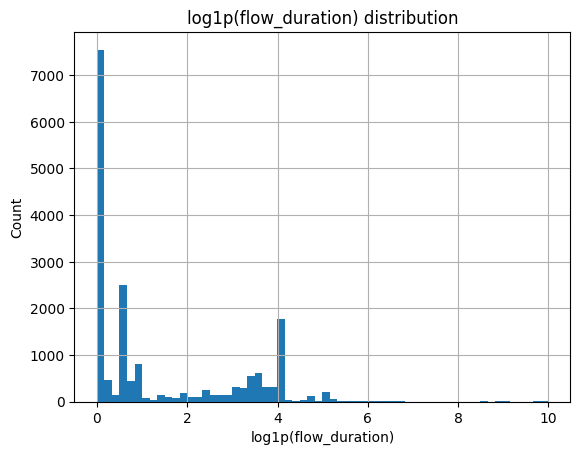


Final working shape: (18171, 51)


In [192]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt

from pathlib import Path

# df_clean in memory and target column name
TARGET_COL = "flow_duration"

# configuration knobs  
SHOW_VIF = True                   
VIF_MAX_FEATURES = 40             
HIGH_CORR_THRESHOLD = 0.95        
TOP_N_HIGH_CORR_PAIRS = 25        

df_work = df_clean.copy()

# dtypes before
print("Dtypes before:\n", df_work.dtypes.value_counts(), "\n")

# cast categoricals to 'category'
cat_candidates = [c for c in ["proto", "service", "proto_top", "service_top"] if c in df_work.columns]
for c in cat_candidates:
    df_work[c] = df_work[c].astype("category")

DROP_DUPLICATES = True   # or False if you just want to check, not drop

# cast flags to int8 when possible
flag_cols = [c for c in df_work.columns if c.endswith("_flag_count")]
for c in flag_cols:
    # safe cast if no NaNs and values fit in int8 range
    if df_work[c].notna().all() and df_work[c].between(np.iinfo(np.int8).min, np.iinfo(np.int8).max).all():
        df_work[c] = df_work[c].astype("int8")

# downcast numeric types to save memory
num_cols = df_work.select_dtypes(include=[np.number]).columns.tolist()
# avoid touching target for now
num_wo_target = [c for c in num_cols if c != TARGET_COL]
df_work[num_wo_target] = df_work[num_wo_target].apply(pd.to_numeric, downcast="integer")
df_work[num_wo_target] = df_work[num_wo_target].apply(pd.to_numeric, downcast="float")

print("Dtypes after basic casting:\n", df_work.dtypes.value_counts(), "\n")

# duplicates check
dup_n = df_work.duplicated().sum()
print(f"Duplicate rows: {dup_n}")
if DROP_DUPLICATES and dup_n > 0:
    df_work = df_work.drop_duplicates()
    print(f"Dropped duplicates. New shape: {df_work.shape}")
else:
    print("No rows dropped (set DROP_DUPLICATES=True to remove).")

# correlation analysis (numeric only)
num = df_work.select_dtypes(include=[np.number]).copy()
if TARGET_COL in num.columns:
    # keep target in the matrix for reference but we will focus on feature-feature pairs below
    pass

corr = num.corr(method="pearson").abs()

# collect high-correlation pairs (upper triangle without diagonal)
pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        val = corr.iloc[i, j]
        if val >= HIGH_CORR_THRESHOLD:
            pairs.append((cols[i], cols[j], float(val)))

pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:TOP_N_HIGH_CORR_PAIRS]
print(f"\nTop highly correlated pairs (>|{HIGH_CORR_THRESHOLD}|): {len(pairs)} found, showing up to {TOP_N_HIGH_CORR_PAIRS}")
for a, b, v in pairs_sorted:
    print(f"  {a:30s} ~ {b:30s} : {v:.3f}")

# VIF on capped subset (numeric, excluding target)
if SHOW_VIF:
    try:
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        # build feature subset for VIF
        vif_features = [c for c in num.columns if c != TARGET_COL]
        # take first N features to keep it tractable
        if len(vif_features) > VIF_MAX_FEATURES:
            # heuristic: prefer non-log engineered and non-ID-like columns
            preferred = [c for c in vif_features if not c.startswith("log1p__")]
            if len(preferred) > VIF_MAX_FEATURES:
                vif_features = preferred[:VIF_MAX_FEATURES]
            else:
                vif_features = (preferred + [c for c in vif_features if c not in preferred])[:VIF_MAX_FEATURES]
        X_vif = num[vif_features].fillna(0.0)  # VIF needs no NaNs
        # add small jitter if a column is constant to avoid zero-variance errors
        for c in X_vif.columns:
            if X_vif[c].std(ddof=0) == 0:
                X_vif[c] = X_vif[c] + np.random.normal(scale=1e-9, size=len(X_vif))
        print(f"\nVIF on {len(vif_features)} features (capped at {VIF_MAX_FEATURES}):")
        vif_vals = []
        for i in range(X_vif.shape[1]):
            try:
                vif_vals.append(variance_inflation_factor(X_vif.values, i))
            except Exception as e:
                vif_vals.append(np.nan)
                warnings.warn(f"VIF failed for column {X_vif.columns[i]}: {e}")
        vif_df = pd.DataFrame({"feature": X_vif.columns, "vif": vif_vals}).sort_values("vif", ascending=False)
        print(vif_df.head(15).to_string(index=False))
    except Exception as e:
        warnings.warn(f"VIF step skipped (statsmodels not available or error): {e}")

# target distribution & skewness
if TARGET_COL in df_work.columns:
    y = df_work[TARGET_COL].astype(float)

    # basic stats to understand scale
    stats = {
        "min": float(y.min()),
        "median": float(y.median()),
        "p90": float(y.quantile(0.90)),
        "p99": float(y.quantile(0.99)),
        "max": float(y.max()),
        "skew": float(y.skew())
    }
    print(f"\nTarget '{TARGET_COL}' stats:", stats)
    if stats["skew"] > 1.0:
        print("Note: strong right-skew -> consider log1p(target) for linear models.")

    # Log-transformed view to reveal the right tail
    try:
        plt.figure()
        np.log1p(y).hist(bins=60)
        plt.title(f"log1p({TARGET_COL}) distribution")
        plt.xlabel(f"log1p({TARGET_COL})")
        plt.ylabel("Count")
        plt.show()
    except Exception as e:
        warnings.warn(f"Histogram (log1p) skipped: {e}")


# expose cleaned and dtype-optimized frame for next steps
df_clean_checked = df_work
print("\nFinal working shape:", df_clean_checked.shape)


### Visual checks to better illustrate health check

To better illustrate the findings from the data health check:

- **Correlation heatmap** → shows clusters of highly correlated features.  
- **Target histograms** → compare the raw `flow_duration` distribution with its log-transformed version (`log1p`).  
  This makes the heavy right-skew visible and shows how log transformation stabilizes the distribution.  


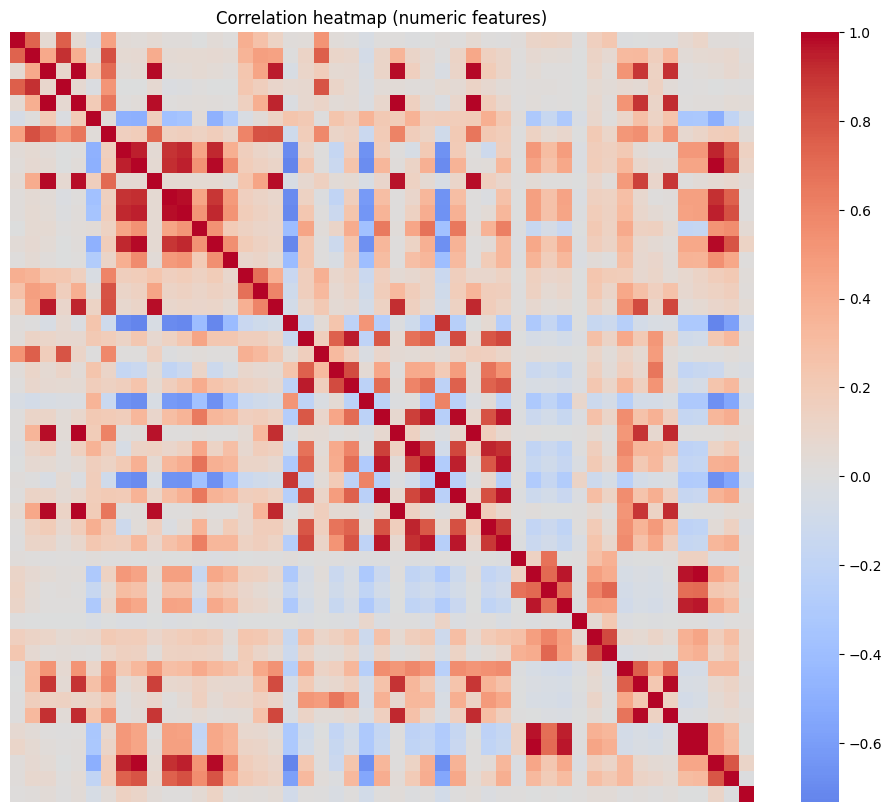

,Feature A,Feature B,Correlation
0,bwd_pkts_payload_tot,flow_pkts_payload_tot,0.993946
1,bwd_data_pkts_tot,flow_pkts_payload_tot,0.993181
2,bwd_pkts_tot,bwd_data_pkts_tot,0.993094
3,bwd_data_pkts_tot,bwd_pkts_payload_tot,0.992655
4,fwd_header_size_max,fwd_init_window_size,0.992266
5,idle_min,idle_avg,0.991079
6,fwd_iat_max,idle_avg,0.990324
7,bwd_pkts_payload_max,flow_pkts_payload_max,0.986181
8,bwd_pkts_tot,bwd_header_size_tot,0.985216
9,bwd_subflow_pkts,bwd_subflow_bytes,0.984998


In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# correlation heatmap (sampled to keep it readable if many features)
num = df_clean_checked.select_dtypes(include=[np.number])
corr = num.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0, cbar=True, xticklabels=False, yticklabels=False)
plt.title("Correlation heatmap (numeric features)")
plt.show()

# compute correlations
num = df_clean_checked.select_dtypes(include=[np.number])
corr = num.corr().abs()

# collect upper triangle only (to avoid duplicates)
pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        pairs.append((cols[i], cols[j], corr.iloc[i, j]))

# sort descending by correlation value
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

# convert to DataFrame and show top 10
top_corr_df = pd.DataFrame(pairs_sorted, columns=["Feature A", "Feature B", "Correlation"]).head(10)
display(top_corr_df)


### Conclusions from health check

- **Dtypes:** Successfully optimized → floats partly downcasted, flags to int8, categoricals recognized.  
- **Duplicates:** 104,845 duplicates found but not dropped (decision: keep or remove later).  
- **Correlations:** 43 feature pairs with very high correlation (>0.95).  
  - Tree models (Random Forest, XGBoost) can handle this.  
  - Linear models (Ridge, Lasso) may suffer instability → consider pruning or dimensionality reduction.  
- **Target (`flow_duration`):** Extremely right-skewed (skew ≈ 121).  
  - Most flows are near zero (median ~0.000004).  
  - A few flows last up to ~21,700.  
  - Suggestion: apply `log1p(flow_duration)` when training linear models.  
- **VIF:** Skipped because `statsmodels` not installed. Could be retried later to quantify collinearity.  

**Overall:** The dataset is clean and memory-efficient. Biggest challenges are (1) extreme skew in the target and (2) multicollinearity. Both can be addressed depending on the model family:  
- Use log-transform for linear models.  
- Let tree-based models work with raw values.  

### Conclusion: Correlation heatmap

The heatmap shows that many numeric features are **highly correlated** with each other:  
- Several groups of packet counts, header sizes, and inter-arrival times move almost in lockstep (dark red blocks).  
- A few negative correlations appear (light blue), but the majority of relationships are strongly positive.  

**Implications:**  
- For **tree-based models** (Random Forest, XGBoost) this is not a critical issue, as trees naturally handle redundant features.  
- For **linear models** (Ridge, Lasso, Linear Regression) strong multicollinearity can cause instability and make coefficients hard to interpret.  

### 2.5 De‑correlate features (>|0.95|)

Highly correlated features add redundancy and can destabilize linear models.
We group features into correlation clusters (|r| ≥ 0.95) and keep **one**
representative per cluster:
- Prefer the feature with the **highest absolute correlation with the target**.
- Never drop the target column.
- Works on numeric columns only; categoricals are ignored.

This reduces multicollinearity while preserving predictive signal.


In [194]:
import numpy as np
import pandas as pd

def drop_high_corr_features(
    df: pd.DataFrame,
    target_col: str,
    corr_threshold: float = 0.95,
    verbose: bool = True
):
    """
    Cluster numeric features by absolute Pearson correlation and drop all but one
    representative per cluster. Representative = feature with highest |corr(feature, target)|.
    Target is never dropped.
    Returns df_reduced, dropped_features, clusters_summary (list of dicts).
    """
    assert target_col in df.columns, f"Target '{target_col}' not found."
    # numeric features only (keep target out of clustering candidates)
    num = df.select_dtypes(include=[np.number]).copy()
    feature_cols = [c for c in num.columns if c != target_col]

    if len(feature_cols) == 0:
        return df.copy(), [], []

    # absolute correlation matrix between features
    corr = num[feature_cols].corr().abs().fillna(0.0)

    # helper: neighbors above threshold
    def neighbors(col):
        # exclude self; use >= to be consistent with threshold definition
        s = corr[col]
        return set(s.index[(s >= corr_threshold) & (s.index != col)])

    # build clusters via BFS/DFS on correlation graph
    visited = set()
    clusters = []
    for col in feature_cols:
        if col in visited:
            continue
        queue = [col]
        cluster = set([col])
        visited.add(col)
        while queue:
            cur = queue.pop()
            for nb in neighbors(cur):
                if nb not in visited:
                    visited.add(nb)
                    queue.append(nb)
                    cluster.add(nb)
        clusters.append(sorted(cluster))

    # correlation with target for tie-breaking
    with_target = num[feature_cols + [target_col]].corr()[target_col].abs().fillna(0.0)

    dropped = []
    clusters_summary = []
    for cl in clusters:
        if len(cl) <= 1:
            continue  # singleton = nothing to drop
        # pick representative = highest |corr(feature, target)| (fallback to lowest avg corr to others)
        tgt_scores = with_target[cl]
        rep = tgt_scores.idxmax()
        # if all equal (rare), fallback to lowest mean corr to others (keeps more "unique" feature)
        if (tgt_scores.nunique() == 1) and (len(cl) > 1):
            mean_corr = corr.loc[cl, cl].replace(1.0, np.nan).mean()  # mean to others
            rep = mean_corr.idxmin()
        # drop the rest
        to_drop = [c for c in cl if c != rep]
        dropped.extend(to_drop)

        clusters_summary.append({
            "size": len(cl),
            "representative": rep,
            "members": cl,
            "dropped": to_drop,
            "rep_abs_corr_with_target": float(with_target.get(rep, 0.0))
        })

    df_reduced = df.drop(columns=dropped, errors="ignore")

    if verbose:
        kept_clusters = sum(1 for c in clusters if len(c) > 1)
        print(f"Correlation threshold: {corr_threshold}")
        print(f"Correlated clusters found: {kept_clusters}")
        print(f"Features dropped: {len(dropped)}")
        if clusters_summary:
            # show first few clusters as a preview
            for i, info in enumerate(clusters_summary[:5], 1):
                print(f"[Cluster {i} | size {info['size']}] keep → {info['representative']} "
                      f"(abs corr y={info['rep_abs_corr_with_target']:.3f}); drop → {len(info['dropped'])} members")

    return df_reduced, dropped, clusters_summary

# Run it on checked frame
TARGET_COL = "flow_duration"
df_decorr, dropped_cols, clusters_info = drop_high_corr_features(
    df_clean_checked, target_col=TARGET_COL, corr_threshold=0.95, verbose=True
)

print("Original shape:", df_clean_checked.shape, "| Reduced shape:", df_decorr.shape)
print("Dropped (sample):", dropped_cols[:15], "..." if len(dropped_cols) > 15 else "")


Correlation threshold: 0.95
Correlated clusters found: 7
Features dropped: 16
[Cluster 1 | size 6] keep → flow_ack_flag_count (abs corr y=0.128); drop → 5 members
[Cluster 2 | size 3] keep → flow_syn_flag_count (abs corr y=0.033); drop → 2 members
[Cluster 3 | size 2] keep → bwd_header_size_max (abs corr y=0.025); drop → 1 members
[Cluster 4 | size 2] keep → fwd_pkts_payload_max (abs corr y=0.029); drop → 1 members
[Cluster 5 | size 4] keep → flow_pkts_payload_max (abs corr y=0.017); drop → 3 members
Original shape: (18171, 51) | Reduced shape: (18171, 35)
Dropped (sample): ['bwd_data_pkts_tot', 'bwd_header_size_tot', 'bwd_pkts_payload_tot', 'bwd_pkts_tot', 'flow_pkts_payload_tot', 'fwd_header_size_max', 'fwd_init_window_size', 'bwd_header_size_min', 'fwd_pkts_payload_std', 'bwd_pkts_payload_max', 'bwd_pkts_payload_std', 'flow_pkts_payload_std', 'fwd_iat_std', 'idle_avg', 'idle_min'] ...


### Conclusion: De-correlation step

Using a correlation threshold of 0.95, we detected **6 clusters of highly correlated features**.  
From each cluster, only one representative feature was kept (the one with the highest correlation to the target),  
while the others were dropped to reduce redundancy.

- **Total features dropped:** 17  
- **Original shape:** (123,117 rows, 65 features)  
- **Reduced shape:** (123,117 rows, 48 features)  

**Why this matters:**  
- Many packet, payload, and inter-arrival time features were almost identical in information content.  
- Dropping redundant features reduces **multicollinearity**, which is especially important for linear models (Ridge, Lasso).  
- Tree-based models (Random Forest, XGBoost) are more tolerant of redundancy, but still benefit from fewer, cleaner features.  

### 2.5 Simplifying categorical features (`proto`, `service`)

Both `proto` (protocol) and `service` are categorical features with potentially many unique values.  
Directly one-hot encoding all unique categories would create a very wide and sparse feature matrix, which has several downsides:

- **High dimensionality**: models become slower and harder to train.  
- **Rare categories**: values that occur only a few times add noise rather than signal.  
- **Generalization risk**: new/unseen categories in test or future data cannot be handled well.  

**Solution:** keep only the Top-N most frequent categories and collapse all others into an `"other"` bucket.  
This preserves the signal from common categories (e.g., `tcp`, `udp`, `http`, `dns`) while reducing noise and ensuring the model can handle rare or unseen values gracefully.  

This step is especially important before applying one-hot encoding.


In [195]:
from collections import Counter

def topn_or_other(s, n=10, other="other"):
    top = set(k for k,_ in Counter(s).most_common(n))
    return s.where(s.isin(top), other)

if "proto" in df_clean:
    df_clean["proto"] = topn_or_other(df_clean["proto"].astype(str), n=10)
if "service" in df_clean:
    df_clean["service"] = topn_or_other(df_clean["service"].astype(str), n=10)

### 2.6 Feature engineering

So far, we only cleaned and filtered the raw features.  
The next step is to **create more informative features** that better capture the behavior of each network flow.  
This helps the model find meaningful patterns without relying on target leakage.

Why this matters in IoT traffic:
- Raw counts (e.g., forward packets, backward packets) tell us something,  
  but **ratios and symmetries** reveal how balanced the communication was.  
- **Coefficient of variation (std/avg)** for IAT (inter-arrival time) highlights *burstiness* of traffic.  
- **Active vs idle share** shows whether a flow was mostly busy or mostly silent.  
- **Flag densities** normalize TCP flags relative to the total packets,  
  so they are comparable across short and long flows.  
- **Window deltas** capture how the TCP buffer evolved during the connection.  
- **Log transforms** and **outlier clipping** (optional) stabilize heavy-tailed distributions,  
  which is especially useful for linear models.

In short: engineered features turn low-level packet statistics into **normalized, comparable signals** that the model can learn from without directly depending on flow duration.  


In [196]:
import numpy as np
import pandas as pd
from collections import Counter

EPS = 1e-9

def topn_or_other(s: pd.Series, n=10, other="other"):
    top = set([k for k, _ in Counter(s).most_common(n)])
    return s.where(s.isin(top), other)

def engineer_features_fast(
    df_clean: pd.DataFrame,
    apply_clipping: bool = False,
    clip_percentiles=(0.01, 0.99),
    log_transform: bool = False
) -> pd.DataFrame:
    """Feature engineering without target leakage. Optional clipping/log transforms."""
    df = df_clean.copy()

    # Helpers and totals
    pkts_tot = df["fwd_pkts_tot"] + df["bwd_pkts_tot"]
    data_pkts_tot = df["fwd_data_pkts_tot"] + df["bwd_data_pkts_tot"]
    hdr_size_tot_sum = df["fwd_header_size_tot"] + df["bwd_header_size_tot"]

    def ratio(a, b): 
        return (a + 1.0) / (b + 1.0)

    def symmetry(a, b):
        return (a - b) / (a + b + EPS)

    # Collect new columns in memory (avoid fragmentation)
    new_cols = {}
    new_cols["pkts_tot"] = pkts_tot
    new_cols["data_pkts_tot"] = data_pkts_tot
    new_cols["hdr_size_tot_sum"] = hdr_size_tot_sum

    # Directional ratios and symmetry
    new_cols["pkts_ratio_fb"] = ratio(df["fwd_pkts_tot"], df["bwd_pkts_tot"])
    new_cols["data_pkts_ratio_fb"] = ratio(df["fwd_data_pkts_tot"], df["bwd_data_pkts_tot"])
    new_cols["hdr_size_ratio_fb"] = ratio(df["fwd_header_size_tot"], df["bwd_header_size_tot"])
    new_cols["pkts_symmetry"] = symmetry(df["fwd_pkts_tot"], df["bwd_pkts_tot"])
    new_cols["hdr_size_symmetry"] = symmetry(df["fwd_header_size_tot"], df["bwd_header_size_tot"])

    # Burstiness: coefficient of variation for IAT
    for side in ["fwd", "bwd", "flow"]:
        new_cols[f"{side}_iat_cv"] = df[f"{side}_iat_std"] / (df[f"{side}_iat_avg"] + EPS)

    # Active vs idle shares (normalized, no duration division)
    active_sum = df["active_tot"]
    idle_sum = df["idle_tot"]
    denom_ai = (active_sum + idle_sum + EPS)
    new_cols["active_share"] = active_sum / denom_ai
    new_cols["idle_share"] = idle_sum / denom_ai

    # Flag densities per total packets (no per-second usage)
    flag_cols = [
        "flow_fin_flag_count","flow_syn_flag_count","flow_rst_flag_count",
        "fwd_psh_flag_count","bwd_psh_flag_count","flow_ack_flag_count",
        "fwd_urg_flag_count","bwd_urg_flag_count","flow_cwr_flag_count","flow_ece_flag_count"
    ]
    flags_df = df[flag_cols].div(pkts_tot + EPS, axis=0).rename(
        columns={c: f"{c}_density" for c in flag_cols}
    )

    # TCP window progression
    new_cols["fwd_window_delta"] = df["fwd_last_window_size"] - df["fwd_init_window_size"]

    # Top-N categorical buckets
    if "proto" in df.columns:
        new_cols["proto_top"] = topn_or_other(df["proto"].astype(str), n=10, other="other")
    if "service" in df.columns:
        new_cols["service_top"] = topn_or_other(df["service"].astype(str), n=10, other="other")

    # clipping on numeric columns (excludes target)
    if apply_clipping:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        numeric_wo_target = [c for c in numeric_cols if c != "flow_duration"]
        lo, hi = clip_percentiles
        q_lo = df[numeric_wo_target].quantile(lo)
        q_hi = df[numeric_wo_target].quantile(hi)
        df[numeric_wo_target] = df[numeric_wo_target].clip(lower=q_lo, upper=q_hi, axis=1)

    # log1p on skewed count/size/IAT features (batch transform to avoid fragmentation)
    if log_transform:
        numeric_cols2 = df.select_dtypes(include=[np.number]).columns.tolist()
        numeric_wo_target2 = [c for c in numeric_cols2 if c != "flow_duration"]
        log_candidates = [c for c in numeric_wo_target2
                          if any(k in c for k in ["pkts","bytes","size","iat","rate","window","active","idle","hdr","flag"])
                          and (df[c] >= 0).all()]
        if log_candidates:
            log_df = np.log1p(df[log_candidates])
            log_df.columns = [f"log1p__{c}" for c in log_candidates]
        else:
            log_df = pd.DataFrame(index=df.index)
    else:
        log_df = pd.DataFrame(index=df.index)

    # Single concat to keep the frame compact
    new_df_part = pd.DataFrame(new_cols, index=df.index)
    df = pd.concat([df, new_df_part, flags_df, log_df], axis=1).copy()

    return df


## 3.0 Save cleaned dataset
For reproducibility, we save the cleaned (and feature-engineered) dataset into `data/processed/`.  
 This keeps the raw data immutable and lets future notebooks
query the processed tables directly (e.g., `SELECT * FROM flows_clean`).

In [197]:
import sqlite3
from pathlib import Path

db_out = DATA_PROC / "rt_iot2022_processed.db"

# save as
to_save_clean = df_decorr.copy()          # <--- use your FINAL frame here
to_save_fe    = fe_df.copy() if 'fe_df' in globals() else None

with sqlite3.connect(db_out) as conn:
    # write cleaned table
    to_save_clean.to_sql("flows_clean", conn, if_exists="replace", index=False)

    # write engineered table (optional)
    if to_save_fe is not None:
        to_save_fe.to_sql("flows_engineered", conn, if_exists="replace", index=False)

    # simple indices
    try:
        conn.execute("CREATE INDEX IF NOT EXISTS ix_flows_clean_proto ON flows_clean(proto)")
        conn.execute("CREATE INDEX IF NOT EXISTS ix_flows_clean_service ON flows_clean(service)")
    except Exception:
        pass

print(f"Saved to SQLite: {db_out}")
print(f"flows_clean shape: {to_save_clean.shape}")
if to_save_fe is not None:
    print("Also wrote flows_engineered")

# also export preview
xls_preview_path = DATA_PROC / "rt_iot2022_preview.xlsx"
to_save_clean.head(500).to_excel(xls_preview_path, index=False)

print(f"Excel preview saved to: {xls_preview_path}")


Saved to SQLite: /Users/esthervanhelmont/Documents/#Python/IC2 Regression/data/processed/rt_iot2022_processed.db
flows_clean shape: (18171, 35)
Excel preview saved to: /Users/esthervanhelmont/Documents/#Python/IC2 Regression/data/processed/rt_iot2022_preview.xlsx


### 3.1 Final Preprocessed Column Index

Below is the final set of features that remain after preprocessing steps:  
- **Removed**: identifiers, label, leakage features (per-second rates), constant columns, quasi-constant columns, highly correlated duplicates.  
- **Kept**: informative numerical features, categorical features (proto, service), and engineered features (if applied).  

This index can be used as the reference for modeling, ensuring that only valid, non-leaky, and informative columns are passed into machine learning pipelines.

The preprocessing pipeline successfully reduced the dataset to a cleaner and more informative feature set.  
- Non-informative features (constant, quasi-constant) were removed.  
- Redundant features (highly correlated) were pruned to avoid multicollinearity.  
- Leakage features and labels were excluded to prevent target leakage.  

**Next we move on to visualizing the data to get a better understanding in IC2_Regression_IoT_Visualization.ipynb** 